# Setup

In [5]:
import numpy as np
import librosa as lr
from scipy import signal
from scipy import misc
from librosa import display
from IPython import display
from IPython.display import Audio
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, output_notebook, show, gridplot
import matplotlib
import math
from matplotlib import pyplot as plt

output_notebook()
%matplotlib notebook

Loading BokehJS ...

In [6]:
plot_scale = 1.

# Zeit-Frequenz Analyse
![pic](title_graphic.png)

In [22]:
l = 512
x = np.linspace(0, 1, l)
patch_x = np.concatenate([[0], x, [1]])
window = lr.filters.get_window('hann', l)
window = np.concatenate([[0], np.linspace(0, 1, l//2 - 1), np.linspace(1, 0, l//2 - 1), [0]])
analysis_freq = 6.

regular_plot = figure(title="regular window", 
                      plot_height=int(plot_scale*300), plot_width=int(plot_scale*800), y_range=(-1.2,1.2))
regular_prod_plot = figure(plot_height=int(plot_scale*300), plot_width=int(plot_scale*800), y_range=(-1.2,1.2))
grid = gridplot([[regular_plot], [regular_prod_plot]])

real_analysis = np.cos(analysis_freq * 2 * np.pi * x) * window
imag_analysis = np.sin(analysis_freq * 2 * np.pi * x) * window

signal_plot = regular_plot.line(x=x, y=x, color="#aaaaaa", line_width=4)
real_analysis_plot = regular_plot.line(x=x, y=real_analysis, color="#2222aa", line_width=2)
imag_analysis_plot = regular_plot.line(x=x, y=imag_analysis, color="#aa2222", line_width=2)
real_product_plot = regular_prod_plot.patch(x=patch_x, y=patch_x, color="#2222aa", alpha=0.5) 
imag_product_plot = regular_prod_plot.patch(x=patch_x, y=patch_x, color="#aa2222", alpha=0.5) 
abs_sum_plot = regular_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#aaaaaa", line_width=4)
real_sum_plot = regular_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#2222aa", line_width=2)
imag_sum_plot = regular_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#aa2222", line_width=2)

def update_analysis_plot(freq=6., phi=0., complex=False):
    sig = np.cos(freq * 2 * np.pi * x + phi)
    
    real_prod = sig * real_analysis
    imag_prod = sig * imag_analysis
    real_sum = np.sum(real_prod) / l
    imag_sum = np.sum(imag_prod) / l
    abs_sum = np.sqrt(real_sum**2 + imag_sum**2)
    
    signal_plot.data_source.data['y'] = sig
    real_product_plot.data_source.data['y'] = real_prod
    imag_product_plot.data_source.data['y'] = imag_prod
    abs_sum_plot.data_source.data['y'] = [abs_sum, abs_sum]
    real_sum_plot.data_source.data['y'] = [real_sum, real_sum]
    imag_sum_plot.data_source.data['y'] = [imag_sum, imag_sum]
    
    
    if complex is True:
       abs_sum_plot.visible = True
       imag_analysis_plot.visible = True
       imag_product_plot.visible = True
       imag_sum_plot.visible = True
    else:
       abs_sum_plot.visible = False
       imag_analysis_plot.visible = False
       imag_product_plot.visible = False
       imag_sum_plot.visible = False
    
    push_notebook()  

show(grid, notebook_handle=True)

In [23]:
interact(update_analysis_plot, freq=(0., 10., 0.1), phi=(0, 6.28, 0.1), complex=False)

In [12]:
def wigner_ville_distribution(x, t=None, N=None):      
    if t is None: 
        t = np.arange(len(x))
    if N is None: 
        N = len(x)
    
    trow = 1
    tcol = t.shape[0]

    xrow = 1
    xcol = x.shape[0]
    
    tfr = np.zeros([N, tcol], dtype='complex')

    for icol in range(tcol):
        ti = t[icol]
        taumax = min([ti, xcol-ti-1, int(round(N/2.0))-1])
        tau = np.arange(-taumax, taumax+1)
        indices = ((N+tau)%N)
        tfr[np.ix_(indices, [icol])] = np.transpose(np.array(x[ti+tau] * np.conj(x[ti-tau]), ndmin=2))
        tau=int(round(N/2))+1
        if ((ti+1) <= (xcol-tau)) and ((ti+1) >= (tau+1)):
            if(tau >= tfr.shape[0]): 
                tfr = np.append(tfr, zeros([1, tcol]), axis=0)
            tfr[np.ix_([tau], [icol])] = np.array(0.5 * (x[ti+tau] * np.conj(x[ti-tau]) + x[ti-tau] * np.conj(x[ti+tau])))
    
    tfr = np.fft.fft(tfr, axis=0)
    f = 0.5*np.arange(N)/float(N)
    return (tfr, t, f )

## Short Time Fourier Transform

<IPython.core.display.Javascript object>


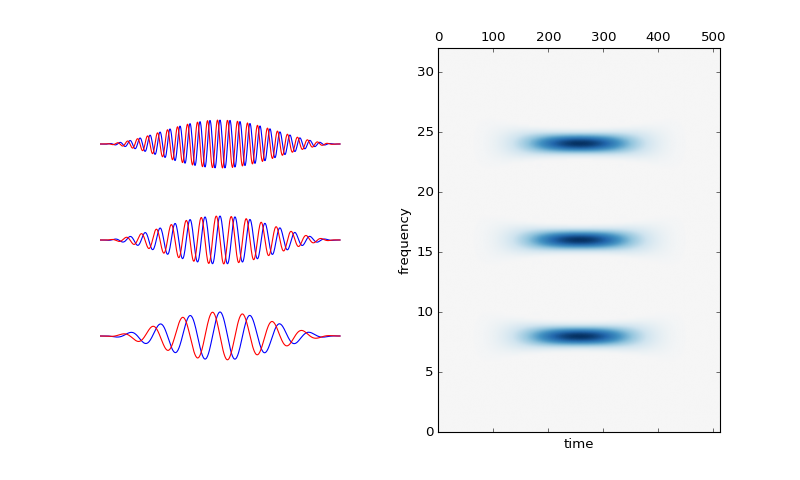

In [13]:
l = 512
window_length = 512
frame_frequencies = [8., 16., 24.]

window_x = np.linspace(0, 2*np.pi, l)
window = np.concatenate([lr.filters.get_window('hann', window_length), np.zeros(l-window_length)])


fig, (td, fd) = plt.subplots(1, 2, figsize=[plot_scale*10, plot_scale*6])

wvd = 0
for freq in frame_frequencies:
    ts = window * np.exp(-1j * freq * window_x)*2
    td.plot(np.real(ts) + freq, color='blue')
    td.plot(np.imag(ts) + freq, color='red')
    ts_wvd, _, _ = wigner_ville_distribution(ts, t=np.arange(l), N=l*4)
    wvd += ts_wvd
wvd_abs = np.abs(wvd)
wvd_max = np.max(wvd_abs)
    
td.set_ylim(0, 32)
td.axis('off')

fd.matshow(wvd_abs[-l//2:, :], 
           origin='upper', aspect='auto', interpolation='bicubic', extent=[0, window_length, 0, 32], 
           cmap='RdBu', vmin=-wvd_max, vmax=np.max(np.abs(wvd)))
fd.set_xlabel('time')
fd.set_ylabel('frequency')

In [15]:
sr = 22050

In [37]:
voice, _ = lr.core.load('voice.wav', sr=sr)
Audio(voice, rate=sr)

In [17]:
queen, _ = lr.core.load('queen.wav', sr=sr)
Audio(queen, rate=sr)

In [18]:
mahler, _ = lr.core.load('mahler.wav', sr=sr)
Audio(mahler, rate=sr)

In [19]:
brahms, _ = lr.core.load('brahms.wav', sr=sr)
Audio(brahms, rate=sr)

<IPython.core.display.Javascript object>


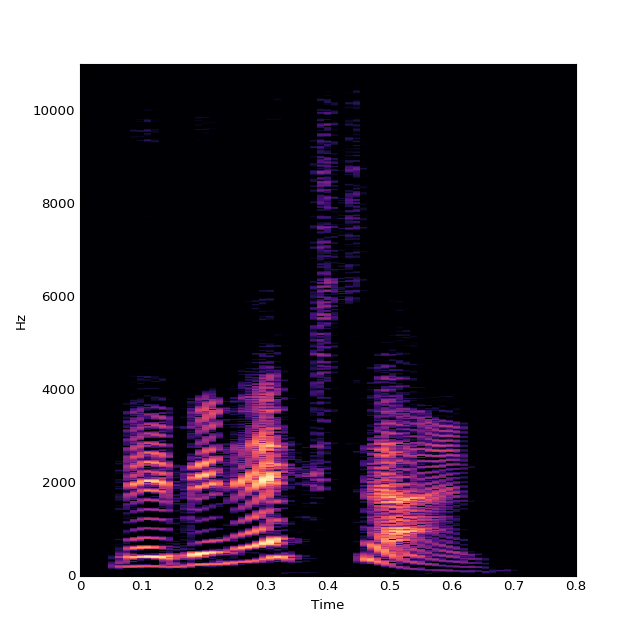

In [82]:
signal = voice
n_fft = 1024
hop_length = 256
stft = lr.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
stft_abs = np.abs(stft)

fig, ax = plt.subplots(1, 1, figsize=[plot_scale*8, plot_scale*8])
lr.display.specshow(lr.amplitude_to_db(stft_abs**2,
                                       ref=np.max),
                    y_axis='linear', x_axis='time', hop_length=hop_length, sr=sr)
Audio(signal, rate=sr)

## FFT

<IPython.core.display.Javascript object>


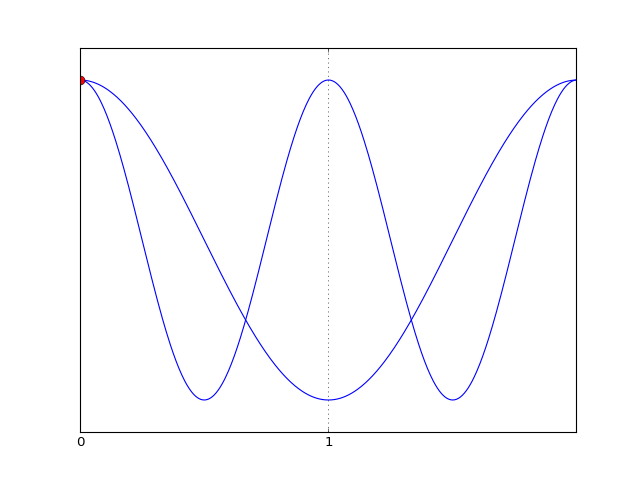

In [21]:
fft_size = 2
resolution = 512
fft_x_res = np.linspace(0, fft_size, resolution, endpoint=False)
fft_x = np.linspace(0, fft_size, fft_size, endpoint=False)
fft_matrix = np.zeros([fft_size, fft_size])

fig, ax = plt.subplots()
for i in range(fft_size):
    ax.plot(fft_x_res, np.cos(2 * np.pi * (fft_x_res / fft_size) * (i+1)), color='blue')
    fft_matrix[:, i] = np.cos(2 * np.pi * (fft_x / fft_size) * (i+1))
ax.set_ylim(-1.2, 1.2)
ax.set_yticks([])
ax.set_xticks(fft_x)
ax.grid()

# detect intersections
points_x = []
points_y = []
for t in range(fft_size):
    dx = np.abs(fft_matrix[t, :, np.newaxis] - fft_matrix[t, np.newaxis, :])
    for i in range(0, fft_size):
        for j in range(i+1, fft_size):
            if dx[i, j] < 0.0001:
                points_x.append(t)
                points_y.append(fft_matrix[t, i])

ax.plot(points_x, points_y, 'ro', markersize=8)

## Rekonstruktion

In [24]:
signal = voice
n_fft = 512
hop_length = n_fft // 4
stft = lr.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
stft_abs = np.abs(stft)
Audio(signal, rate=sr)

### Zero Phase

In [25]:
zero_phase_stft = stft_abs * np.exp(1j * 0)
zero_phase_reconstruction = lr.core.istft(zero_phase_stft, hop_length=hop_length)
Audio(zero_phase_reconstruction, rate=sr)

### Random Phase

In [349]:
noise = np.random.rand(signal.shape[0])
noise_stft = lr.core.stft(noise, n_fft=n_fft, hop_length=hop_length)
noisy_phase_stft = stft_abs * np.exp(1j * np.angle(noise_stft))
noisy_phase_reconstruction = lr.core.istft(noisy_phase_stft, hop_length=hop_length)
Audio(noisy_phase_reconstruction, rate=sr)

### Griffin-Lim

<IPython.core.display.Javascript object>


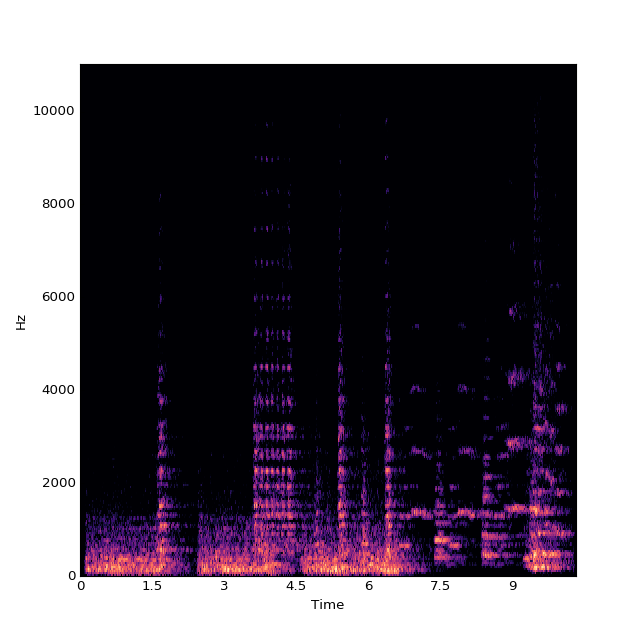

In [358]:
reconstruction_stft = lr.core.stft(noisy_phase_reconstruction, n_fft=n_fft, hop_length=hop_length)
reconstruction_stft_abs = np.abs(reconstruction_stft)

fig, ax = plt.subplots(1, 1, figsize=[plot_scale*8, plot_scale*8])
lr.display.specshow(lr.amplitude_to_db(reconstruction_stft_abs**2,
                                       ref=np.max),
                    y_axis='linear', x_axis='time', hop_length=hop_length, sr=sr)

corrected_stft = stft_abs * np.exp(1j * np.angle(reconstruction_stft))
noisy_phase_reconstruction = lr.core.istft(corrected_stft, hop_length=hop_length)
Audio(noisy_phase_reconstruction, rate=sr)

In [355]:
def reconstruct_griffin_lim(stft_abs, hop_length, iterations=100):
    n_fft = int((stft_abs.shape[0]-1) * 2)
    time_slices = stft_abs.shape[1] - 1
    len_samples = int(time_slices*hop_length)
    reconstructed_signal = np.random.randn(len_samples)
    for i in range(iterations):
        reconstruction_stft = lr.core.stft(reconstructed_signal, n_fft=n_fft, hop_length=hop_length)
        corrected_stft = stft_abs * np.exp(1.0j * np.angle(reconstruction_stft))
        reconstructed_signal = lr.core.istft(corrected_stft, hop_length=hop_length)
    return reconstructed_signal

In [359]:
reconstructed = reconstruct_griffin_lim(stft_abs, hop_length=hop_length, iterations=100)
Audio(reconstructed, rate=sr)

<IPython.core.display.Javascript object>


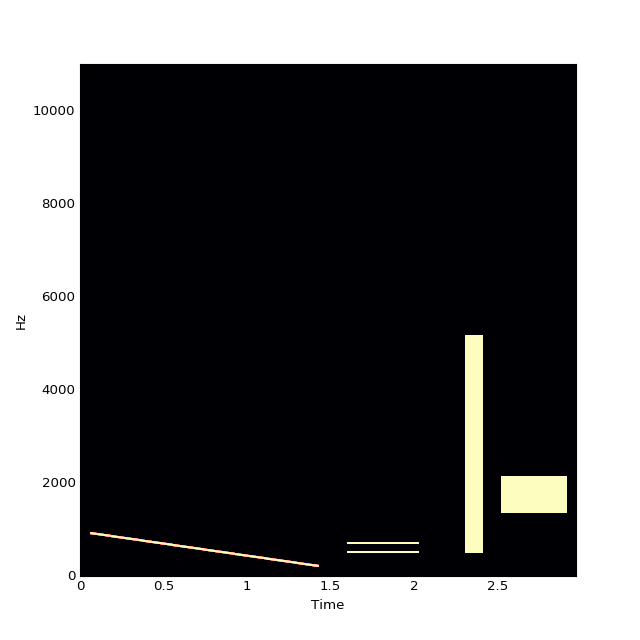

In [553]:
picture = misc.imread('spec_draw_1.png', mode='F')
picture = (np.max(picture) - picture[::-1, :]) / np.max(picture)

fig, ax = plt.subplots(1, 1, figsize=[plot_scale*8, plot_scale*8])
lr.display.specshow(lr.amplitude_to_db(picture**2,
                                       ref=np.max),
                    y_axis='linear', x_axis='time', hop_length=hop_length, sr=sr)

reconstructed = reconstruct_griffin_lim(picture, hop_length=hop_length, iterations=100)
Audio(reconstructed, rate=sr)

## Mel Spektogramm und MFCC

### Mel Scale

<IPython.core.display.Javascript object>


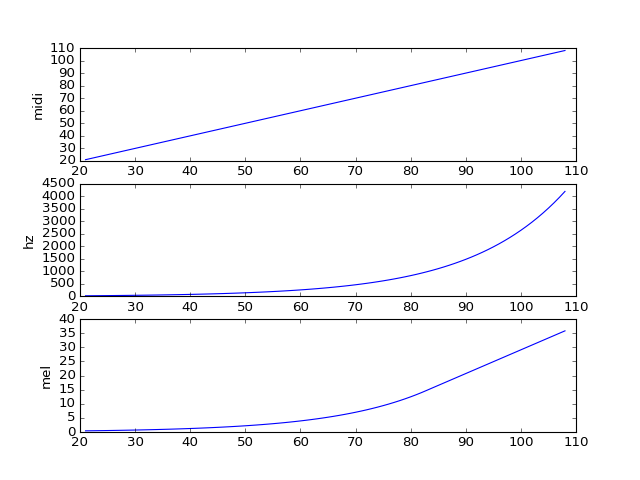

In [370]:
l = 512
midi_sweep = np.linspace(21, 108, 88)
hz_sweep = lr.midi_to_hz(midi_sweep)
mel_sweep = lr.hz_to_mel(hz_sweep)

fig, (midi, hz, mel) = plt.subplots(3, 1)
midi.plot(midi_sweep, midi_sweep)
midi.set_ylabel('midi')
hz.plot(midi_sweep, hz_sweep)
hz.set_ylabel('hz')
mel.plot(midi_sweep, mel_sweep)
mel.set_ylabel('mel')

### Mel Spektogramm

<IPython.core.display.Javascript object>


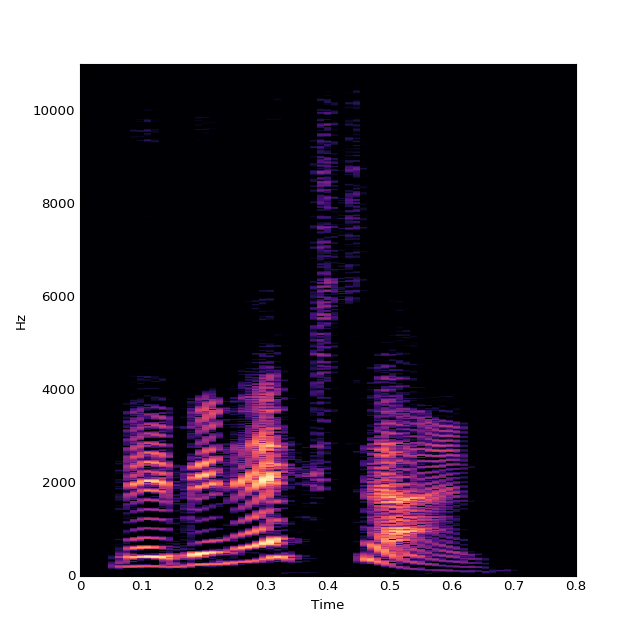

In [554]:
signal = voice
n_fft = 1024
hop_length = n_fft // 4
stft = lr.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
stft_abs = np.abs(stft)
log_spectogram = lr.amplitude_to_db(stft_abs**2,
                                       ref=np.max)

fig, ax = plt.subplots(1, 1, figsize=[plot_scale*8, plot_scale*8])
lr.display.specshow(log_spectogram,
                    y_axis='linear', x_axis='time', hop_length=hop_length, sr=sr)
Audio(signal, rate=sr)

### MFCC
Mel Frequency Cepstral Coefficients

<IPython.core.display.Javascript object>


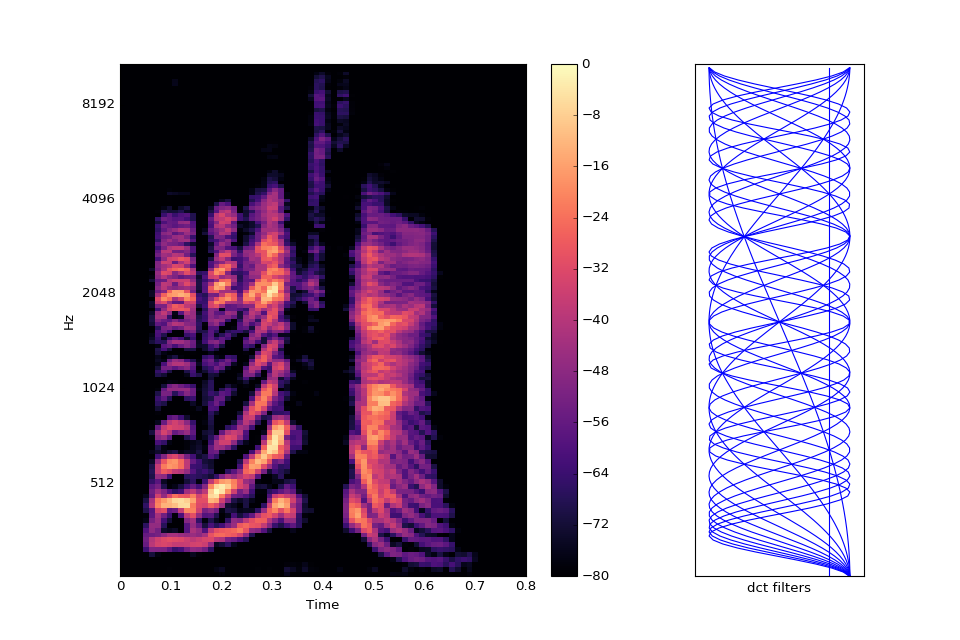

In [555]:
n_mfcc = 13
mel_spectogram = lr.feature.melspectrogram(S=stft_abs**2, sr=sr)
log_mel_spectogram = lr.amplitude_to_db(mel_spectogram, ref=np.max)
mel_bins = log_mel_spectogram.shape[0]
dct_filters = lr.filters.dct(n_mfcc, mel_bins)

fig, (ax, dct) = plt.subplots(1, 2, figsize=[plot_scale*12, plot_scale*8], gridspec_kw = {'width_ratios':[3, 1]})
for i in range(n_mfcc):
    dct.plot(dct_filters[i,:], np.arange(0, log_mel_spectogram.shape[0]), color='blue')
dct.set_ylim(0, mel_bins)
dct.set_yticks([])
dct.set_xlabel('dct filters')
dct.set_xticks([])
plt.sca(ax)
lr.display.specshow(log_mel_spectogram,
                    y_axis='mel', x_axis='time', hop_length=hop_length, sr=sr)
plt.colorbar()

<IPython.core.display.Javascript object>


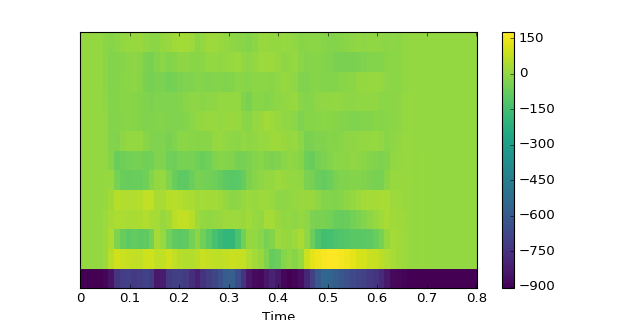

In [556]:
mfccs = lr.feature.mfcc(S=log_mel_spectogram, n_mfcc=n_mfcc)
fig, ax = plt.subplots(1, 1, figsize=[plot_scale*8, plot_scale*4])
lr.display.specshow(mfccs, x_axis='time', hop_length=hop_length, sr=sr, cmap='viridis')
plt.colorbar()

### MFCC Rekonstruktion

<IPython.core.display.Javascript object>


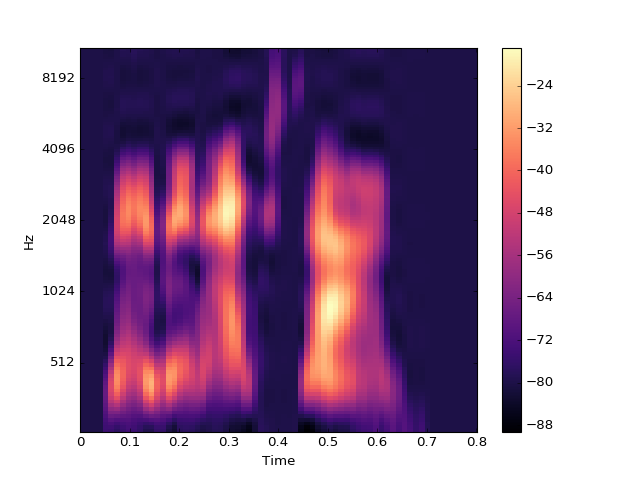

In [557]:
reconstructed_mel_spectogram = np.dot(np.transpose(dct_filters), mfccs)
fix, ax = plt.subplots()
lr.display.specshow(reconstructed_mel_spectogram,
                    y_axis='mel', x_axis='time', hop_length=hop_length, sr=sr)
plt.colorbar()

<IPython.core.display.Javascript object>


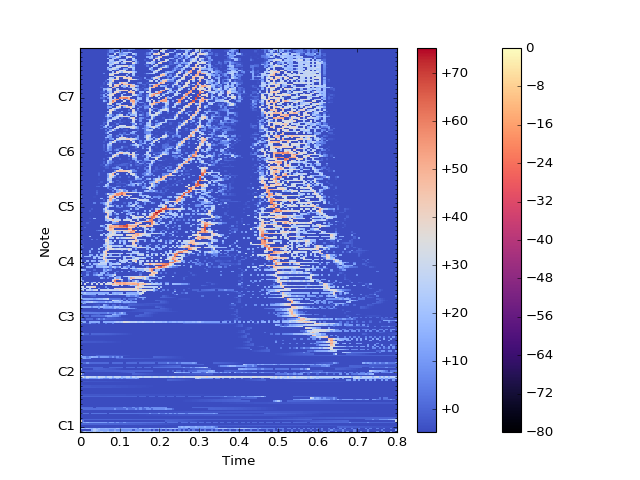

In [558]:
melfb = lr.filters.mel(sr, n_fft)
reconstructed_spectogram = np.dot(np.linalg.pinv(melfb), reconstructed_mel_spectogram)
reconstructed_spectogram *= (np.min(reconstructed_mel_spectogram) / np.min(reconstructed_spectogram))
reconstructed_spectogram = np.clip(reconstructed_spectogram, -80, 0)
reconstructed_spectogram[melfb.shape[1]-40:, :] = reconstructed_spectogram[melfb.shape[1]-40:, :] * 0 - 80
fix, ax = plt.subplots()
lr.display.specshow(reconstructed_spectogram,
                    y_axis='linear', x_axis='time', hop_length=hop_length, sr=sr)
plt.colorbar()

In [559]:
reconstructed_stft_abs = np.sqrt(lr.db_to_power(reconstructed_spectogram, 1.))
reconstructed = reconstruct_griffin_lim(reconstructed_stft_abs, hop_length=hop_length, iterations=100)
Audio(reconstructed, rate=sr)

## Constant Q (Wavelet) Transform

<IPython.core.display.Javascript object>


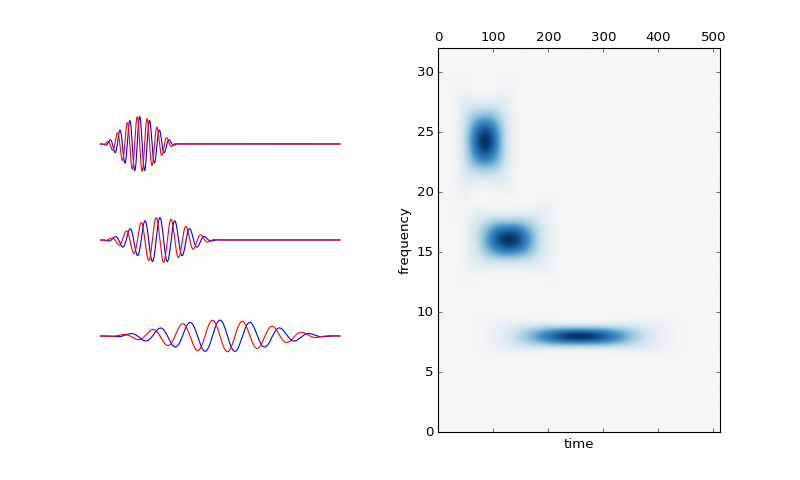

In [667]:
l = 512
q = 8.
frame_frequencies = [8., 16., 24.]

window_x = np.linspace(0, 2*np.pi, l)
window = lr.filters.get_window('hann', l)
wavelet = np.exp(-1j * q * window_x) * window

fig, (td, fd) = plt.subplots(1, 2, figsize=[plot_scale*10, plot_scale*6])

wvd = 0
for freq in frame_frequencies:
    width = int(l * q / freq)
    this_wavelet = np.interp(np.linspace(0, 2*np.pi, width), window_x, wavelet) / np.sqrt(width) * 30.
    if width < l:
        this_wavelet = np.pad(this_wavelet, [0, l - width], mode='constant', constant_values=(0, 0))
    td.plot(np.real(this_wavelet) + freq, color='blue')
    td.plot(np.imag(this_wavelet) + freq, color='red')
    ts_wvd, _, _ = wigner_ville_distribution(this_wavelet, t=np.arange(l), N=l*4)
    wvd += ts_wvd
wvd_abs = np.abs(wvd)
wvd_max = np.max(wvd_abs)
    
td.set_ylim(0, 32)
td.axis('off')

fd.matshow(wvd_abs[-l//2:, :], 
           origin='upper', aspect='auto', interpolation='bicubic', extent=[0, window_length, 0, 32], 
           cmap='RdBu', vmin=-wvd_max, vmax=np.max(np.abs(wvd)))
fd.set_xlabel('time')
fd.set_ylabel('frequency')

<IPython.core.display.Javascript object>


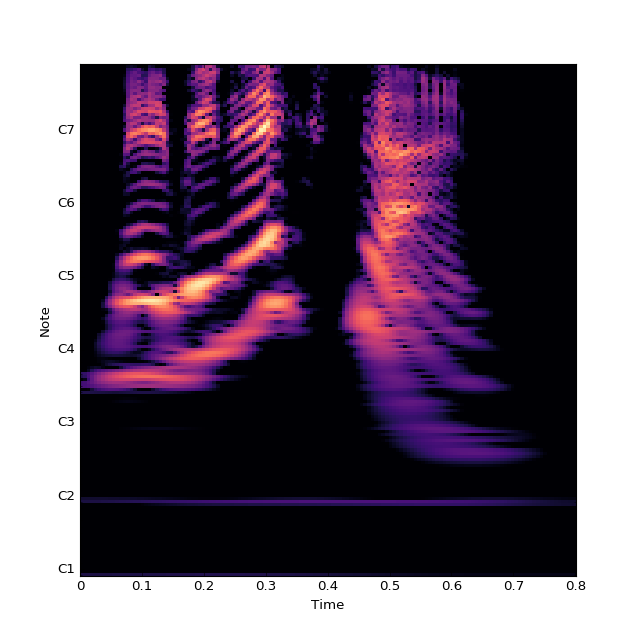

In [43]:
signal = voice
bins_per_octave=24
octaves = 7
fmin = 30.
hop_length=128
filter_scale = 1.

cqt = lr.core.cqt(signal, sr=sr, hop_length=hop_length, bins_per_octave=bins_per_octave, 
                  n_bins=bins_per_octave*octaves, fmin=fmin, filter_scale=filter_scale)  

fig, ax = plt.subplots(1, 1, figsize=[plot_scale*8, plot_scale*8])
lr.display.specshow(lr.amplitude_to_db(np.abs(cqt)**2, ref=np.max),
                    y_axis='cqt_note', x_axis='time', hop_length=hop_length, sr=sr, bins_per_octave=bins_per_octave,
                    fmin=fmin, cmap='magma')
plt.show()
Audio(signal, rate=sr)

## Reassignment

### Time Reassignment

In [733]:
l = 512
x = np.linspace(0, 1, l)
patch_x = np.concatenate([[0], x, [1]])
window = lr.filters.get_window('tri', l)
window_tw = window * (x - 0.5) * 6.
window_td = np.diff(window) * l / 4.
window_td = np.concatenate([[0], window_td[1:], [0]])
analysis_freq = 6.

regular_plot = figure(title="regular window", plot_height=300, plot_width=500, y_range=(-1.2,1.2))
regular_prod_plot = figure(plot_height=300, plot_width=500, y_range=(-1.2,1.2))
r_plot = figure(title="time derivative window", plot_height=300, plot_width=500, y_range=(-1.2,1.2))
r_prod_plot = figure(plot_height=300, plot_width=500, y_range=(-1.2,1.2))
grid = gridplot([[regular_plot, r_plot], [regular_prod_plot, r_prod_plot]])

real_analysis = np.cos(analysis_freq * 2 * np.pi * x) * window
imag_analysis = np.sin(analysis_freq * 2 * np.pi * x) * window
r_real_analysis = np.cos(analysis_freq * 2 * np.pi * x) * window_tw
r_imag_analysis = np.sin(analysis_freq * 2 * np.pi * x) * window_tw

signal_plot = regular_plot.line(x=x, y=x, color="#aaaaaa", line_width=4)
window_plot = regular_plot.line(x=x, y=window, color="#22aa22", line_width=2)
real_analysis_plot = regular_plot.line(x=x, y=real_analysis, color="#2222aa", line_width=2)
imag_analysis_plot = regular_plot.line(x=x, y=imag_analysis, color="#aa2222", line_width=2)
real_product_plot = regular_prod_plot.patch(x=patch_x, y=patch_x, color="#2222aa", alpha=0.5) 
imag_product_plot = regular_prod_plot.patch(x=patch_x, y=patch_x, color="#aa2222", alpha=0.5) 
abs_sum_plot = regular_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#aaaaaa", line_width=4)
real_sum_plot = regular_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#2222aa", line_width=2)
imag_sum_plot = regular_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#aa2222", line_width=2)


r_signal_plot = r_plot.line(x=x, y=x, color="#aaaaaa", line_width=4)
r_window_plot = r_plot.line(x=x, y=window_tw, color="#22aa22", line_width=2)
r_real_analysis_plot = r_plot.line(x=x, y=r_real_analysis, color="#2222aa", line_width=2)
r_imag_analysis_plot = r_plot.line(x=x, y=r_imag_analysis, color="#aa2222", line_width=2)
r_real_product_plot = r_prod_plot.patch(x=patch_x, y=patch_x, color="#2222aa", alpha=0.5) 
r_imag_product_plot = r_prod_plot.patch(x=patch_x, y=patch_x, color="#aa2222", alpha=0.5)
r_abs_sum_plot = r_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#aaaaaa", line_width=4)
r_real_sum_plot = r_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#2222aa", line_width=2)
r_imag_sum_plot = r_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#aa2222", line_width=2)


def update_reassignment_plot(pos=0.5):
    sig = x*0
    w = l/analysis_freq * 0.5
    sig[max(int(pos*l - w/2 + 0.5), 0):min(int(pos*l + w/2 + 0.5),l)] += 1.0
    #sig = np.cos(freq * 2 * np.pi * x + phi)
    
    real_prod = sig * real_analysis
    imag_prod = sig * imag_analysis
    real_sum = np.sum(real_prod) / l * analysis_freq
    imag_sum = np.sum(imag_prod) / l * analysis_freq
    abs_sum = np.sqrt(real_sum**2 + imag_sum**2)
    
    signal_plot.data_source.data['y'] = sig
    real_product_plot.data_source.data['y'] = real_prod
    imag_product_plot.data_source.data['y'] = imag_prod
    real_sum_plot.data_source.data['y'] = [real_sum, real_sum]
    imag_sum_plot.data_source.data['y'] = [imag_sum, imag_sum]
    imag_sum_plot.data_source.data['y'] = [imag_sum, imag_sum]
    abs_sum_plot.data_source.data['y'] = [abs_sum, abs_sum]
    
    r_real_prod = sig * r_real_analysis
    r_imag_prod = sig * r_imag_analysis
    r_real_sum = np.sum(r_real_prod) / l * analysis_freq
    r_imag_sum = np.sum(r_imag_prod) / l * analysis_freq
    r_abs_sum = np.sqrt(r_real_sum**2 + r_imag_sum**2)
    
    r_signal_plot.data_source.data['y'] = sig
    r_real_product_plot.data_source.data['y'] = r_real_prod
    r_imag_product_plot.data_source.data['y'] = r_imag_prod
    r_real_sum_plot.data_source.data['y'] = [r_real_sum, r_real_sum]
    r_imag_sum_plot.data_source.data['y'] = [r_imag_sum, r_imag_sum]
    r_abs_sum_plot.data_source.data['y'] = [r_abs_sum, r_abs_sum]
    
    push_notebook()    
    
show(grid, notebook_handle=True)

In [734]:
interact(update_reassignment_plot, pos=(0., 1., 0.01))

### Frequency Reassignment

In [713]:
l = 512
x = np.linspace(0, 1, l)
patch_x = np.concatenate([[0], x, [1]])
window = lr.filters.get_window('tri', l)
window_tw = window + x - 0.5
window_td = np.diff(window) * l / 4.
window_td = np.concatenate([[0], window_td[1:], [0]])
analysis_freq = 6.

regular_plot = figure(title="regular window", plot_height=300, plot_width=500, y_range=(-1.2,1.2))
regular_prod_plot = figure(plot_height=300, plot_width=500, y_range=(-1.2,1.2))
r_plot = figure(title="time derivative window", plot_height=300, plot_width=500, y_range=(-1.2,1.2))
r_prod_plot = figure(plot_height=300, plot_width=500, y_range=(-1.2,1.2))
grid = gridplot([[regular_plot, r_plot], [regular_prod_plot, r_prod_plot]])

real_analysis = np.cos(analysis_freq * 2 * np.pi * x) * window
imag_analysis = np.sin(analysis_freq * 2 * np.pi * x) * window
r_real_analysis = np.cos(analysis_freq * 2 * np.pi * x) * window_td
r_imag_analysis = np.sin(analysis_freq * 2 * np.pi * x) * window_td

signal_plot = regular_plot.line(x=x, y=x, color="#aaaaaa", line_width=4)
window_plot = regular_plot.line(x=x, y=window, color="#22aa22", line_width=2)
real_analysis_plot = regular_plot.line(x=x, y=real_analysis, color="#2222aa", line_width=2)
imag_analysis_plot = regular_plot.line(x=x, y=imag_analysis, color="#aa2222", line_width=2)
real_product_plot = regular_prod_plot.patch(x=patch_x, y=patch_x, color="#2222aa", alpha=0.5) 
imag_product_plot = regular_prod_plot.patch(x=patch_x, y=patch_x, color="#aa2222", alpha=0.5) 
abs_sum_plot = regular_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#aaaaaa", line_width=4)
real_sum_plot = regular_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#2222aa", line_width=2)
imag_sum_plot = regular_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#aa2222", line_width=2)


r_signal_plot = r_plot.line(x=x, y=x, color="#aaaaaa", line_width=4)
r_window_plot = r_plot.line(x=x, y=window_td, color="#22aa22", line_width=2)
r_real_analysis_plot = r_plot.line(x=x, y=r_real_analysis, color="#2222aa", line_width=2)
r_imag_analysis_plot = r_plot.line(x=x, y=r_imag_analysis, color="#aa2222", line_width=2)
r_real_product_plot = r_prod_plot.patch(x=patch_x, y=patch_x, color="#2222aa", alpha=0.5) 
r_imag_product_plot = r_prod_plot.patch(x=patch_x, y=patch_x, color="#aa2222", alpha=0.5)
r_abs_sum_plot = r_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#aaaaaa", line_width=4)
r_real_sum_plot = r_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#2222aa", line_width=2)
r_imag_sum_plot = r_prod_plot.line(x=[0., 1.], y=[0., 0.], color="#aa2222", line_width=2)


def update_reassignment_plot(freq=6., phi=0.):
    sig = np.cos(freq * 2 * np.pi * x + phi)
    
    real_prod = sig * real_analysis
    imag_prod = sig * imag_analysis
    real_sum = np.sum(real_prod) / l
    imag_sum = np.sum(imag_prod) / l
    abs_sum = np.sqrt(real_sum**2 + imag_sum**2)
    
    signal_plot.data_source.data['y'] = sig
    real_product_plot.data_source.data['y'] = real_prod
    imag_product_plot.data_source.data['y'] = imag_prod
    real_sum_plot.data_source.data['y'] = [real_sum, real_sum]
    imag_sum_plot.data_source.data['y'] = [imag_sum, imag_sum]
    imag_sum_plot.data_source.data['y'] = [imag_sum, imag_sum]
    abs_sum_plot.data_source.data['y'] = [abs_sum, abs_sum]
    
    r_real_prod = sig * r_real_analysis
    r_imag_prod = sig * r_imag_analysis
    r_real_sum = np.sum(r_real_prod) / l
    r_imag_sum = np.sum(r_imag_prod) / l
    r_abs_sum = np.sqrt(r_real_sum**2 + r_imag_sum**2)
    
    r_signal_plot.data_source.data['y'] = sig
    r_real_product_plot.data_source.data['y'] = r_real_prod
    r_imag_product_plot.data_source.data['y'] = r_imag_prod
    r_real_sum_plot.data_source.data['y'] = [r_real_sum, r_real_sum]
    r_imag_sum_plot.data_source.data['y'] = [r_imag_sum, r_imag_sum]
    r_abs_sum_plot.data_source.data['y'] = [r_abs_sum, r_abs_sum]
    
    push_notebook()    
    
show(grid, notebook_handle=True)

In [714]:
interact(update_reassignment_plot, freq=(0., 10., 0.1), phi=(0, 6.28, 0.1))

<function __main__.update_reassignment_plot>

### STFT Reassignment

In [44]:
def hann_t(n):
    '''
    time weighed hann window
    '''
    x = np.linspace(-1, 1, n, endpoint=False)
    return x * (np.cos(np.pi * x)*0.5 + 0.5)

def hann_dt(n):
    '''
    time derivative of the hann window
    '''
    x = np.linspace(0, 2, n, endpoint=False)
    return 0.5 * np.sin(np.pi * x)

In [45]:
def stft_reassignment(x, 
                      n_fft=512, 
                      hop_length=None, 
                      sr=22050, 
                      reassignment_hop_length=None,
                      reassignment_n_fft=None):
    stft = lr.core.stft(x, n_fft, hop_length, window='hann')
    stft_abs = np.abs(stft)
    stft_sq = stft_abs**2
    stft_t = lr.core.stft(x, n_fft, hop_length, window=hann_t)
    stft_dt = lr.core.stft(x, n_fft, hop_length, window=hann_dt)
    
    if reassignment_hop_length is None:
        reassignment_hop_length = hop_length
        
    if reassignment_n_fft is None:
        reassignment_n_fft = n_fft
    
    n_bins = stft.shape[0]
    time_steps = stft.shape[1]
    reassignment_bins = math.ceil(n_bins * (reassignment_n_fft / n_fft))
    reassignment_time_steps = math.ceil(time_steps * (hop_length / reassignment_hop_length))
    print("rs time steps", reassignment_time_steps)
    
    frequencies = lr.core.fft_frequencies(sr=sr, n_fft=n_fft)
    fmin = frequencies[1]
    
    bin_factor = reassignment_n_fft / n_fft
    print("bin factor", bin_factor)
    time_factor = reassignment_time_steps / time_steps
    print("time factor", time_factor)
    
    frequency_shifts = np.imag(stft_dt * np.conj(stft)) / stft_sq
    frequency_shifts = np.nan_to_num(frequency_shifts) * fmin
    
    time_shifts = np.real(stft_t * np.conj(stft)) / stft_sq
    time_shifts = np.nan_to_num(time_shifts) * (n_fft / hop_length) * 0.5 * time_factor
    
    reassigned_stft = np.zeros([reassignment_bins, reassignment_time_steps])
    
    for b in range(n_bins):
        for t in range(time_steps):
            f_bin = math.floor(b * bin_factor)
            t_bin = math.floor(t * time_factor)
            if stft_sq[b, t] > 0.01:
                freq = frequencies[b] + frequency_shifts[b, t]
                f_bin = math.floor(bin_factor * freq / fmin + 0.5)
                f_bin = min(max(f_bin, 0), reassignment_bins-1)
                #print("freq: " + str(frequencies[b]) + 
                #      ", freq_shift: " + str(frequency_shifts[b, t]) + 
                #      ", f_bin: " + str(f_bin))
                
                t_bin = math.floor(t * time_factor + time_shifts[b, t] + 0.5)
                t_bin = min(max(t_bin, 0), reassignment_time_steps-1)
            else:
                frequency_shifts[b, t] = 0
                time_shifts[b, t] = 0

            reassigned_stft[f_bin, t_bin] += stft_abs[b, t] 
    return reassigned_stft

rs time steps 276
bin factor 1.0
time factor 2.0


<IPython.core.display.Javascript object>


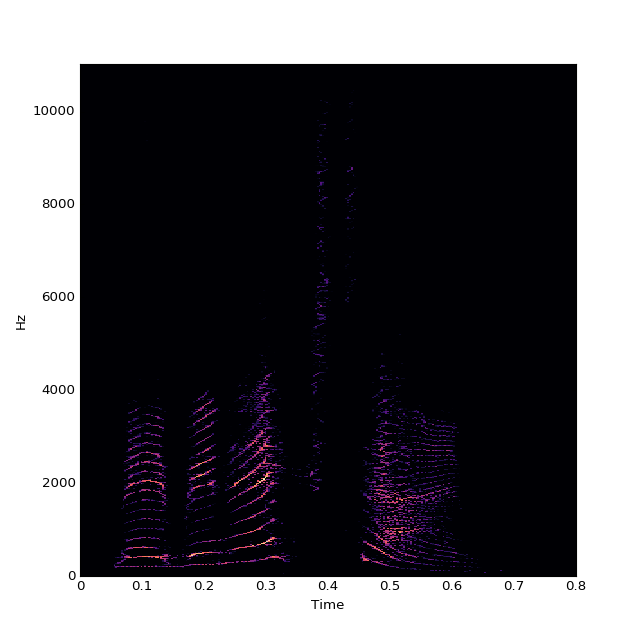

In [64]:
signal = voice
n_fft = 1024
hop_length = 128
reassignment_hop_length=64
reassignment_n_fft=1024
reassigned_stft = stft_reassignment(signal, 
                                    n_fft, 
                                    hop_length=hop_length, 
                                    sr=sr,
                                    reassignment_hop_length=reassignment_hop_length,
                                    reassignment_n_fft=reassignment_n_fft)

fig, ax = plt.subplots(1, 1, figsize=[plot_scale*8, plot_scale*8])
lr.display.specshow(lr.amplitude_to_db(reassigned_stft**2, ref=np.max),
                    y_axis='linear', x_axis='time', hop_length=reassignment_hop_length, sr=sr)
plt.show()
Audio(signal, rate=sr)

### CQT Reassignment

In [65]:
def cqt_reassignment(x, 
                     sr=22050, 
                     hop_length=512, 
                     fmin=lr.note_to_hz('C1'), 
                     n_bins=84, 
                     bins_per_octave=12, 
                     tuning=0.0, 
                     filter_scale=1,
                     reassignment_hop_length=None,
                     reassignment_bins_per_octave=None):
    
    # frequencies and filter lengths of the constant q filters
    frequencies = lr.core.cqt_frequencies(n_bins, fmin, bins_per_octave, tuning)
    filter_lengths = lr.filters.constant_q_lengths(sr, fmin, n_bins, bins_per_octave, tuning, 'hann', filter_scale).reshape(-1, 1)
    
    scaling = (1/filter_lengths**0.5)
    scaling = scaling.reshape(-1,1)
    
    # ordinary constant q transform
    cqt = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                      bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                      window='hann', scale=False, norm=np.inf) * scaling
    
    # cqt with time weighed window for time reassignment
    cqt_t = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                        bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                        window=hann_t, scale=False, norm=np.inf) * scaling
    
    # cqt with time derivative window for frequency reassignment
    cqt_dt = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                         bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                         window=hann_dt, scale=False, norm=np.inf) * scaling 
    
    time_steps = cqt.shape[1]
    
    if reassignment_hop_length is None:
        reassignment_hop_length = hop_length
        
    if reassignment_bins_per_octave is None:
        reassignment_bins_per_octave = bins_per_octave
        
    reassignment_bins = math.ceil(n_bins * (reassignment_bins_per_octave / bins_per_octave))
    reassignment_time_steps = math.ceil(time_steps * (hop_length / reassignment_hop_length))
    
    cqt_abs = np.abs(cqt)
    cqt_sq = cqt_abs**2
    
    frequency_shifts =  np.imag(cqt_dt * np.conj(cqt)) / (filter_lengths * cqt_sq)
    frequency_shifts = np.nan_to_num(frequency_shifts) * sr * 0.5 
    
    time_shifts = np.real(filter_lengths * cqt_t * np.conj(cqt) / cqt_sq)
    time_shifts = np.nan_to_num(time_shifts) / reassignment_hop_length * 0.131
    
    reassigned_cqt = np.zeros([reassignment_bins, reassignment_time_steps])
    oct_min = lr.hz_to_octs(fmin)
    
    bin_factor = reassignment_bins / n_bins
    time_factor = reassignment_time_steps / time_steps
    
    # fill the reassignmed scalogram
    for b in range(n_bins):
        for t in range(time_steps):
            f_bin = math.floor(b * bin_factor)
            t_bin = math.floor(t * time_factor)
            
            if cqt_abs[b, t] > 1.: # only reassign if there is enough energy
                freq = frequencies[b] + frequency_shifts[b, t]
                freq = max(freq, fmin)
                f_bin = math.floor((lr.hz_to_octs(freq) - oct_min) * reassignment_bins_per_octave + 0.5)
                f_bin = min(max(f_bin, 0), reassignment_bins-1)
                
                t_bin = math.floor(t * time_factor + time_shifts[b, t] + 0.5)
                t_bin = min(max(t_bin, 0), reassignment_time_steps-1)

            reassigned_cqt[f_bin, t_bin] += cqt_abs[b, t] 
            
    return reassigned_cqt

<IPython.core.display.Javascript object>


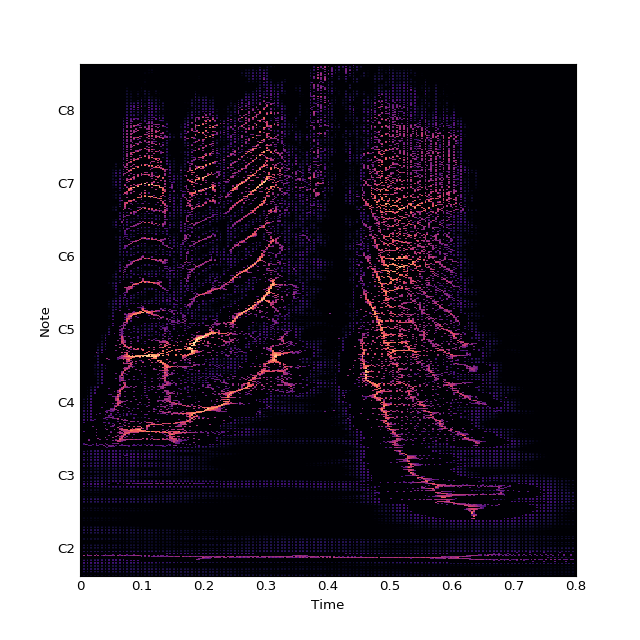

In [80]:
signal = voice
bins_per_octave=48
octaves = 7
fmin = 50.
hop_length=128
filter_scale = 0.5
reassignment_hop_length=64
reassignment_bins_per_octave=72

reassigned_cqt = cqt_reassignment(signal, 
                                  sr=sr, 
                                  n_bins=octaves*bins_per_octave, 
                                  bins_per_octave=bins_per_octave,
                                  filter_scale=filter_scale, 
                                  hop_length=hop_length,
                                  fmin=fmin,
                                  reassignment_hop_length=reassignment_hop_length,
                                  reassignment_bins_per_octave=reassignment_bins_per_octave)   

fig, ax = plt.subplots(1, 1, figsize=[plot_scale*8, plot_scale*8])
lr.display.specshow(lr.amplitude_to_db(reassigned_cqt**1.2, ref=np.max),
                    y_axis='cqt_note', x_axis='time', hop_length=reassignment_hop_length, sr=sr, bins_per_octave=reassignment_bins_per_octave,
                    fmin=fmin, cmap='magma')
plt.show()
Audio(signal, rate=sr)